In [23]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [25]:
len(words)

32033

In [26]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words)))) # All individual words in the dataset
stoi = {s:i+1 for i,s in enumerate(chars)} # String to integer mapping
stoi['.'] = 0 # In the vocabulary doen't exist the '.' character by default, we include it at the first position
itos = {i:s for s,i in stoi.items()} # Integer to string mapping
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [27]:
characters_integer = []
for ch in 'emma':
    characters_integer.append(stoi[ch])

print(torch.tensor(characters_integer))

tensor([ 5, 13, 13,  1])


In [28]:
# Build the dataset

block_size = 3 # Context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        # Creates a list with three elements, each of which is 0
        # This context list will be a sliding window always containing the previous three characters
        # in order to predict the next
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            # Our input data now will be a context of size three different to the context of size one we builded
            # in the previous code lab
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            # Update the context window to include the lastest character while discarding the oldesde one
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% of the words
n2 = int(0.9*len(words)) # 90% of the words

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [34]:
n_embd = 10 # The dimensionality of the character embedding vectors
n_hidden = 200 # The number of neurons in the hidden layer of the MLP


g = torch.Generator().manual_seed(2147483647)
# Each character is represented by a continuous vector of a fixed size (n_embd in this case)
# These embeddings are learned during training and can capture more information about characters
# in a more conpact form than one-hot vectors
C = torch.randn((27, n_embd), generator=g) # Character embedding matrix
W1 = torch.randn((30, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

# Number of parameters in total
print(sum(p.nelement() for p in parameters))

for param in parameters:
    param.requires_grad = True

11897


In [39]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y
    
    
    # Forward pass
    emb = C[Xb] # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # Output layer
    loss = F.cross_entropy(logits, Yb)

    
    # Backward pass
    # We want to set the gradients to be zero
    for param in parameters:
        param.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 100000 else 0.01
    for param in parameters:
        param.data += -lr * param.grad
        
        
    # Track stats
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:  {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000:  3.1857


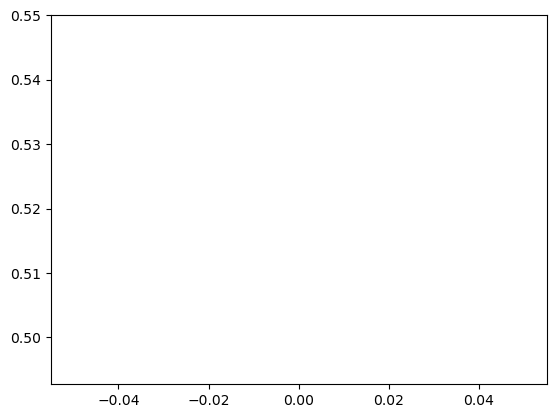

In [36]:
plt.plot(lossi)

In [37]:
# We don't want to keep the computation graph in order to compute gradients
# which are only needed during the training phase
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size, n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 3.1878931522369385
val 3.187795877456665


### Sample from the model

In [17]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # Initialize with all ... [0, 0, 0]
    while True:
        # Forward pass the NN
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # If we sample the special '.' token, break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # Decode and print the generated word

mona.
mayah.
see.
mel.
ryla.
ren.
ruchadrael.
aderronelin.
shy.
jenne.
elionna.
arleit.
kollyan.
noshuberghairiel.
kendreth.
konnterco.
uszande.
ryyah.
fael.
yuma.


### Parameters initialization

In [24]:
# The probability expected at the beginning should be 1/27 if all the characters have the
# same probability to be chosen

In [18]:
# Negative Log likelihood
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [ ]:
# The loss at the begining is bigger than the expected.
# Actual:  27.8817
# Expected: 3.2958

# Note:
#     In training a neural network it is almost the case that we
#     will have a rough idea for what loss to expect at initialization

In [47]:
# The activation of the hidden states
# Most of the values by far take on the value of negative one and one

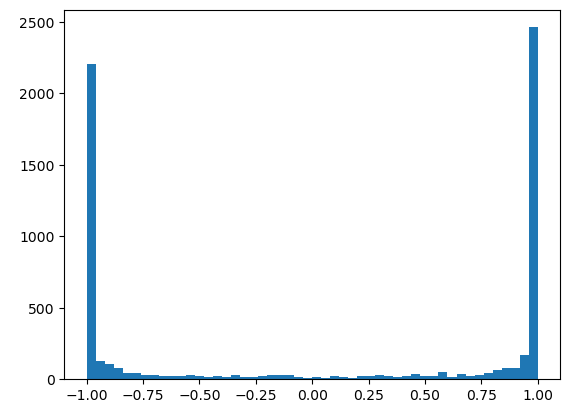

In [ ]:
# Pre-activations feed into the tanh are very broad, these takes numbers between [-20, 20]
# and that's why in the tanh() everything is being sqashed and capped to be in the range of 
# negative one and one

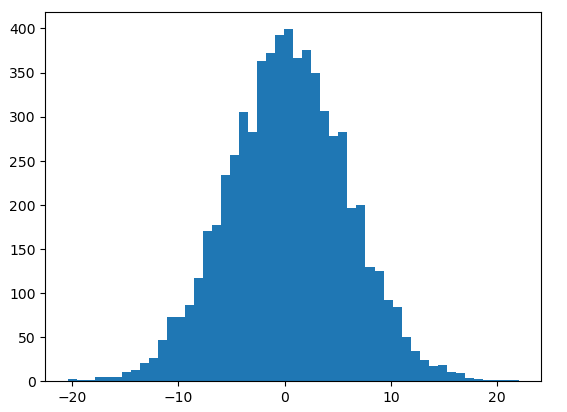

In [48]:
# Let's see how often `h` is in the flat region which causes that backpropagation
# pass directly through the neuron without effect in its gradient because 
# if t is 1 or -1 the sqare of it is 1 and (1 - 1) is zero then the gradient is set to 0
# i.e., self.grad += (1 - t**2) * out.grad

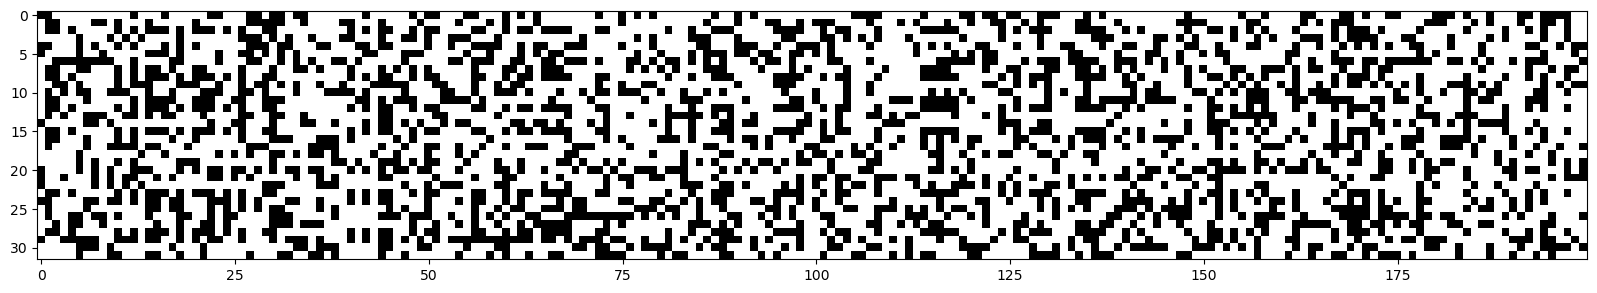

In [49]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

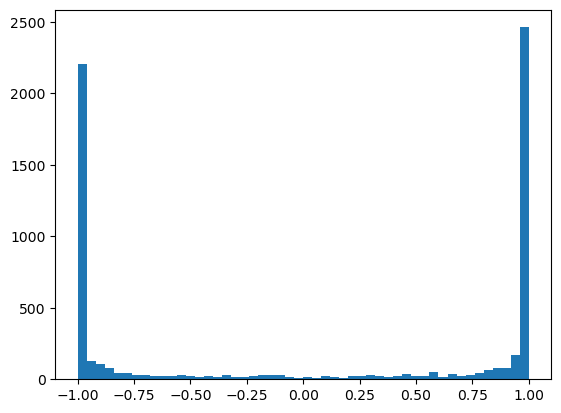

In [46]:
plt.hist(h.view(-1).tolist(), 50);

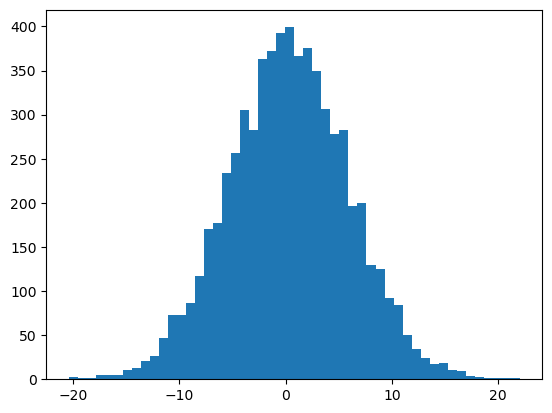

In [45]:
plt.hist(hpreact.view(-1).tolist(), 50);